# Import

In [1]:
!pip -q install torch-fidelity lpips opencv-python matplotlib tqdm
!pip install -q albumentations==1.4.7
!pip -q install scikit-image

import os, glob, random, cv2, numpy as np
from tqdm import tqdm
from skimage.exposure import match_histograms
import albumentations as A
import zipfile, pathlib, requests
import os, glob, math, random, shutil
from pathlib import Path
import cv2
import torch
import torchvision.transforms as T
from torchvision.utils import save_image
from torch.nn.utils import spectral_norm
import matplotlib.pyplot as plt
from tqdm import tqdm
import lpips
from PIL import Image
import numpy as np
import torch.nn as nn
from torch_fidelity import calculate_metrics
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
import torchvision.transforms.functional as TF
import torchvision.utils as vutils
import pandas as pd
import math
import gdown
import zipfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 kB 9.3 MB/s eta 0:00:00


In [2]:
zip_path = "archive.zip"

if os.path.exists(zip_path):
    os.remove(zip_path)

gdown.download(id="1_HPn3NogV4NPD88i1Y9jDgUbr-dQKuHS", output=zip_path, quiet=False)

os.makedirs("dataset", exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("dataset")

for root, dirs, files in os.walk("dataset"):
    print(root, len(files))

Downloading...
From (original): https://drive.google.com/uc?id=1_HPn3NogV4NPD88i1Y9jDgUbr-dQKuHS
From (redirected): https://drive.google.com/uc?id=1_HPn3NogV4NPD88i1Y9jDgUbr-dQKuHS&confirm=t&uuid=66244154-10bc-4997-a5d5-b27d7d275054
To: /content/archive.zip
100%|██████████| 4.45G/4.45G [01:43<00:00, 42.8MB/s]


dataset 0
dataset/Teeth Segmentation PNG 1
dataset/Teeth Segmentation PNG/d2 0
dataset/Teeth Segmentation PNG/d2/masks_machine 598
dataset/Teeth Segmentation PNG/d2/ann 598
dataset/Teeth Segmentation PNG/d2/img 598
dataset/Teeth Segmentation PNG/d2/masks_human 598
dataset/Teeth Segmentation JSON 2
dataset/Teeth Segmentation JSON/d2 0
dataset/Teeth Segmentation JSON/d2/masks_machine 598
dataset/Teeth Segmentation JSON/d2/ann 598
dataset/Teeth Segmentation JSON/d2/img 598
dataset/Teeth Segmentation JSON/d2/masks_human 598


# Globals

In [17]:
IMG_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 15
LR = 1e-4
LAMBDA_L1 = 70.0
LAMBDA_PERC = 10.0

IMG_DIR  = "/content/dataset/Teeth Segmentation PNG/d2/img"
MASK_DIR = "/content/dataset/Teeth Segmentation PNG/d2/masks_human"
PNG_ROOT  = "/content/dataset/Teeth Segmentation PNG/d2"
JSON_ROOT = "/content/dataset/Teeth Segmentation JSON/d2"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"

#Utils


In [4]:
#utils
def crop_right(pil_img, frac=0.5):
    w, h = pil_img.size
    left = int(w * (1 - frac))
    return pil_img.crop((left, 0, w, h))

def denorm_tanh(x):
    return (x.clamp(-1, 1) + 1) * 0.5

def gray3(x):
    if x.is_cuda:
        x = x.detach().cpu()
    x01 = denorm_tanh(x.float())
    # ripeti il canale per avere RGB
    return x01.repeat(1, 3, 1, 1)

def list_files(d):
    exts = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")
    return [f for f in os.listdir(d) if f.lower().endswith(exts)]

def to_map(dirpath):
    return {os.path.splitext(f)[0]: os.path.join(dirpath, f) for f in list_files(dirpath)}

def pick_triplet(root, key=None, crop_right_half=True, disp_size=(256,256)):
    IMG_DIR = os.path.join(root, "img")
    HUM_DIR = os.path.join(root, "masks_human")
    MAC_DIR = os.path.join(root, "masks_machine")

def denorm(x):  # [-1,1] -> [0,1]
    return (x.clamp(-1,1) + 1) * 0.5

def save_grid(tensor, path, nrow=4):
    vutils.save_image(denorm(tensor), path, nrow=nrow)

    # mappe filename->path
    img_map = to_map(IMG_DIR)
    hum_map = to_map(HUM_DIR)
    mac_map = to_map(MAC_DIR)

    common = sorted(set(img_map) & set(hum_map) & set(mac_map))
    assert common, f"Nessun match tra img/masks_human/masks_machine in {root}"

    # se viene passato un key e c'è, usalo, altrimenti scegli a caso
    if key is None or key not in common:
        key = random.choice(common)

    # load
    img = Image.open(img_map[key]).convert("L")   # X-ray
    hum = Image.open(hum_map[key]).convert("RGB") # mask human
    mac = Image.open(mac_map[key]).convert("RGB") # mask machine

    # crop metà destra della human (opzionale)
    if crop_right_half:
        w, h = hum.size
        hum = hum.crop((w//2, 0, w, h))

    # resize uniformi per visualizzazione
    img_v = img.resize(disp_size, Image.BICUBIC)
    hum_v = hum.resize(disp_size, Image.NEAREST)
    mac_v = mac.resize(disp_size, Image.NEAREST)

    return (img_v, hum_v, mac_v, key)

def list_files(d):
    exts = (".png",".jpg",".jpeg",".bmp",".tif",".tiff")
    return sorted([f for f in os.listdir(d) if f.lower().endswith(exts)])

#trasformations.
aug_geo = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.04, scale_limit=0.05, rotate_limit=7,
                       border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=0.8),
    A.ElasticTransform(alpha=5, sigma=5, alpha_affine=5,
                        border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=0.2),
])

to_img = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE), interpolation=T.InterpolationMode.BICUBIC),
    T.Grayscale(),                     # radiografie in 1 canale
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5]) # [-1, 1]
])

to_msk = T.Compose([
    T.Lambda(lambda im: crop_right(im, 0.5)),
    T.Resize((IMG_SIZE, IMG_SIZE), interpolation=T.InterpolationMode.NEAREST),
    T.Grayscale(),
    T.ToTensor(),                       # [0,1]
    T.Lambda(lambda t: (t > t.median()).float()),
    T.Normalize([0.5],[0.5])            # [-1,1]
])

In [5]:
# utils useful for network
def get_norm(norm_type: str, num_feats: int):
    norm_type = norm_type.lower()
    if norm_type in ["bn", "batch", "batchnorm", "batch_norm"]:
        return nn.BatchNorm2d(num_feats)
    elif norm_type in ["in", "instance", "instancenorm", "instance_norm"]:
        return nn.InstanceNorm2d(num_feats, affine=False, track_running_stats=False)
    else:
        raise ValueError(f"norm_type non supportato: {norm_type}")

def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)
    elif isinstance(m, (nn.BatchNorm2d, nn.InstanceNorm2d)):
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.normal_(m.weight, 1.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias, 0.0)


In [6]:
# utility in synthetic part
def to01_gray(p, size):
    im = Image.open(p).convert("L").resize((size,size), Image.BICUBIC)
    return np.asarray(im, np.float32)/255.0  # HxW

def mean_std_dir_gray(d, size):
    files = [f for f in os.listdir(d) if f.lower().endswith((".png",".jpg",".jpeg",".bmp",".tif",".tiff"))]
    s = 0.0; s2 = 0.0; n = 0
    for f in files:
        x = to01_gray(os.path.join(d,f), size)
        s  += x.sum()
        s2 += (x**2).sum()
        n  += x.size
    mu = s/n; sd = max(1e-6, np.sqrt(s2/n - mu**2))
    return mu, sd

def match_mean_std_dir(syn_dir, out_dir, real_dir, size):
    os.makedirs(out_dir, exist_ok=True)
    mu_r, sd_r = mean_std_dir_gray(real_dir, size)
    mu_s, sd_s = mean_std_dir_gray(syn_dir,  size)
    for f in tqdm(sorted(os.listdir(syn_dir)), desc=f"Mean-Std match → {os.path.basename(out_dir)}"):
        if not f.lower().endswith((".png",".jpg",".jpeg",".bmp",".tif",".tiff")): continue
        x = to01_gray(os.path.join(syn_dir,f), size)
        y = (x - mu_s)/sd_s*sd_r + mu_r
        y = np.clip(y, 0, 1)
        y3 = np.stack([y,y,y], -1)
        Image.fromarray((y3*255).astype(np.uint8)).save(os.path.join(out_dir, f))


def _list_images(dir_path, exts=("png","jpg","jpeg","bmp","tif","tiff")):
    p = Path(dir_path)
    files = []
    for e in exts:
        files.extend(p.glob(f"*.{e}"))   # niente graffe
    return sorted(files)

def list_images(d):
    exts = ("*.png","*.jpg","*.jpeg","*.bmp","*.tif","*.tiff")
    files = []
    for e in exts: files.extend(glob.glob(os.path.join(d, e)))
    return sorted(files)


def stems_set(d):
    return set(q.stem for q in _list_images(d))

def ensure_clean_dir(d):
    d = Path(d); d.mkdir(parents=True, exist_ok=True)
    for f in d.iterdir():
        if f.is_file(): f.unlink()

def ensure_clean_dir(d):
    d = Path(d); d.mkdir(parents=True, exist_ok=True)
    for f in d.iterdir():
        if f.is_file(): f.unlink()

def make_real3_from_stems(stems, img_dir, out_dir, size):
    ensure_clean_dir(out_dir)
    saved, miss = 0, []
    for stem in stems:
        rp = find_real_path(stem, img_dir)
        if rp is None:
            miss.append(stem); continue
        im  = Image.open(rp).convert("L").resize((size,size), Image.BICUBIC)
        arr = np.array(im, dtype=np.uint8)
        rgb = np.stack([arr,arr,arr], axis=-1)
        Image.fromarray(rgb).save(Path(out_dir)/f"{stem}.png")
        saved += 1
    print(f"[REAL3] salvati {saved} file in {out_dir}. Mancanti: {len(miss)}")
    if miss: print("  esempi mancanti:", miss[:10])
    return saved

def count_imgs(d): return len(_list_images(d))

@torch.no_grad()
def lpips_mean_between_dirs(dir_real, dir_syn, n=200, seed=0, size=None):
    rng = random.Random(seed)
    rfs = [f for f in os.listdir(dir_real) if f.lower().endswith((".png",".jpg",".jpeg",".bmp",".tif",".tiff"))]
    sfs = [f for f in os.listdir(dir_syn)  if f.lower().endswith((".png",".jpg",".jpeg",".bmp",".tif",".tiff"))]
    rfs.sort(); sfs.sort()
    assert rfs and sfs, "Cartelle vuote per LPIPS"
    rng.shuffle(rfs); rng.shuffle(sfs)
    m = min(n, len(rfs), len(sfs))
    vals = []
    for i in range(m):
        xr = Image.open(os.path.join(dir_real, rfs[i])).convert("RGB")
        xs = Image.open(os.path.join(dir_syn,  sfs[i])).convert("RGB")
        if size is not None:
            xr = xr.resize((size,size))
            xs = xs.resize((size,size))
        xr = (TF.to_tensor(xr)*2-1).unsqueeze(0).to(DEVICE)
        xs = (TF.to_tensor(xs)*2-1).unsqueeze(0).to(DEVICE)
        vals.append(float(perc(xs, xr).mean().item()))
    mu = float(np.mean(vals))
    sd = float(np.std(vals, ddof=1)) if len(vals)>1 else 0.0
    return mu, sd

def eval_dirs(real_dir, syn_dir, device_is_cuda, kid_subset_size=None, kid_subset_count=50, img_size=None):
    N_real, N_syn = count_imgs(real_dir), count_imgs(syn_dir)
    assert N_real > 0 and N_syn > 0, f"Immagini mancanti: real={N_real}, syn={N_syn}"
    if kid_subset_size is None:
        kid_subset_size = min(100, N_real, N_syn)
    else:
        kid_subset_size = min(int(kid_subset_size), N_real, N_syn)
    m = calculate_metrics(
        input1=real_dir, input2=syn_dir,
        cuda=bool(device_is_cuda), batch_size=64,
        fid=True,
        kid=True, kid_subset_size=kid_subset_size, kid_subset_count=kid_subset_count,
        prc=False, prdc=False, isc=False, verbose=False
    )
    lp_mu, lp_sd = lpips_mean_between_dirs(real_dir, syn_dir, n=min(200, N_real, N_syn), size=img_size)
    return {
        "N_real": N_real, "N_syn": N_syn,
        "fid":        float(m["frechet_inception_distance"]),
        "kid_mean":   float(m["kernel_inception_distance_mean"]),
        "kid_std":    float(m["kernel_inception_distance_std"]),
        "lpips_mean": lp_mu,
        "kid_subset_size": kid_subset_size,
        "kid_subset_count": kid_subset_count,
    }

def norm(s):
    s = s.strip().lower()
    if s.isdigit():
        return str(int(s))   # elimina zeri davanti
    return s

def find_real_path(stem, img_dir):
    from pathlib import Path
    img_dir = Path(img_dir)

    # candidati di nome: stem, versione numerica senza zeri e vari zero-padded
    names = [stem]
    if stem.isdigit():
        nz = str(int(stem))                 # "000522" -> "522"
        names += [nz] + [nz.zfill(w) for w in (3,4,5,6)]
    # aggiungi suffissi comuni
    extra = []
    for s in names:
        extra += [s + "_img", s + "-img", s + "_image", s + "-image"]
    names += extra

    # prova estensioni case-insensitive
    exts = (".png",".jpg",".jpeg",".bmp",".tif",".tiff",
            ".PNG",".JPG",".JPEG",".BMP",".TIF",".TIFF")

    for name in names:
        for ext in exts:
            q = img_dir / f"{name}{ext}"
            if q.is_file():
                return q

    # fallback: match per stem normalizzato (rimuovi zeri di testa)
    nstem = stem.lower().lstrip("0") or "0"
    for p in img_dir.iterdir():
        if p.is_file():
            ps = p.stem.lower()
            if ps.lstrip("0") or "0" == nstem:
                if (ps == stem.lower()) or (ps.lstrip("0") == nstem):
                    return p
    return None

def looks_like_mask(img_u8):
    vals = np.unique(img_u8)
    if len(vals) <= 8:
        # percentuale di pixel in {0,255} o {0,1}
        zeros = (img_u8 == 0).mean()
        ones  = (img_u8 == 1).mean()
        two55 = (img_u8 == 255).mean()
        if (zeros + two55) > 0.95 or (zeros + ones) > 0.95:
            return True
    return False

def iter_xray_files(root):
    for p in list_images(root):
        name_low = os.path.basename(p).lower()
        if any(tok in name_low for tok in ["mask", "_m", "-m", "label", "seg"]):
            continue
        if any(seg in p.lower().split(os.sep) for seg in ["mask", "masks", "labels", "annotations"]):
            continue
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        if looks_like_mask(img):
            continue
        yield p, img

#Data

In [8]:
# dataset creation class
class TeethDataset(Dataset):
    def __init__(self, img_dir, mask_dir, to_img, to_msk, augment=False):
        exts = (".png",".jpg",".jpeg",".bmp",".tif",".tiff")
        imgs = {os.path.splitext(f)[0]: os.path.join(img_dir, f)
                for f in os.listdir(img_dir) if f.lower().endswith(exts)}
        msks = {os.path.splitext(f)[0]: os.path.join(mask_dir, f)
                for f in os.listdir(mask_dir) if f.lower().endswith(exts)}

        self.keys = sorted(set(imgs) & set(msks))
        assert self.keys, "Nessuna coppia img↔mask trovata"

        self.imgs = imgs
        self.msks = msks
        self.to_img = to_img
        self.to_msk = to_msk
        self.augment = augment

        self.return_paths = False

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        k = self.keys[idx]

        pil_img = Image.open(self.imgs[k]).convert("L")
        pil_msk = Image.open(self.msks[k])

        if pil_msk.size != pil_img.size:
            pil_msk = pil_msk.resize(pil_img.size, Image.NEAREST)

        pil_msk = pil_msk.convert("L")

        if self.augment:
            out = aug_geo(image=np.array(pil_img), mask=np.array(pil_msk))
            pil_img = Image.fromarray(out["image"])
            pil_msk = Image.fromarray(out["mask"])

        img = self.to_img(pil_img)
        msk = self.to_msk(pil_msk)

        #
        if self.return_paths:
            return msk, img, self.msks[k]
        return msk, img


In [9]:
class WithMaskPath(Dataset):

    def __init__(self, base):
        self.base = base

    def __len__(self):
        return len(self.base)

    def _resolve(self, idx):
        ds = self.base
        # gestisce Subset annidati
        true_idx = idx
        while isinstance(ds, Subset):
            true_idx = ds.indices[true_idx]
            ds = ds.dataset
        # ora ds è il TeethDataset originale
        return ds, true_idx

    def __getitem__(self, idx):
        # prendo i tensori dal dataset originale (o Subset)
        msk, img = self.base[idx]
        ds, true_idx = self._resolve(idx)
        k = ds.keys[true_idx]
        mask_path = ds.msks[k]
        return msk, img, mask_path

def canonical_stem(mask_path: str) -> str:
    s = Path(mask_path).stem
    for suf in ['_mask','-mask','_seg','-seg','_label','-label']:
        if s.endswith(suf): return s[:-len(suf)]
    return s

def make_gen_loader(ref_loader):
    ds_with_paths = WithMaskPath(ref_loader.dataset)
    return DataLoader(
        ds_with_paths,
        batch_size=getattr(ref_loader, 'batch_size', 1),
        shuffle=False,                              # importante per l’allineamento
        num_workers=getattr(ref_loader, 'num_workers', 0),
        pin_memory=getattr(ref_loader, 'pin_memory', False),
        drop_last=False
    )

Train samples: 796  |  Val samples: 200
batch img torch.Size([8, 1, 256, 256])  |  batch msk torch.Size([8, 1, 256, 256])


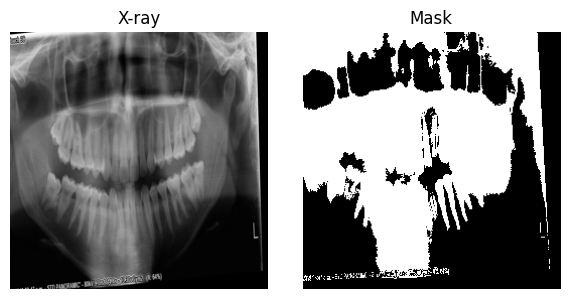

In [10]:
base_noaug = TeethDataset(IMG_DIR, MASK_DIR, to_img, to_msk, augment=False)
base_aug   = TeethDataset(IMG_DIR, MASK_DIR, to_img, to_msk, augment=True)

#####
N   = len(base_noaug)
idx = np.random.permutation(N)
n_val   = min(200, N-1)
val_idx = idx[:n_val]
train_idx = idx[n_val:]


train_ds = ConcatDataset([
    Subset(base_noaug, train_idx),
    Subset(base_aug,   train_idx),
])
val_ds   = Subset(base_noaug, val_idx)


train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_ds)}  |  Val samples: {len(val_ds)}")

msk_b, img_b = next(iter(train_loader))

print(f"batch img {img_b.shape}  |  batch msk {msk_b.shape}")
j = np.random.randint(0, img_b.size(0))

# plot del sample j (denormalizzato)
fig, ax = plt.subplots(1, 2, figsize=(6,3))
ax[0].imshow(denorm(img_b[j]).squeeze(0).cpu(), cmap="gray"); ax[0].set_title("X-ray"); ax[0].axis("off")
ax[1].imshow(denorm(msk_b[j]).squeeze(0).cpu(), cmap="gray"); ax[1].set_title("Mask");  ax[1].axis("off")
plt.tight_layout(); plt.show()

#Network

In [12]:
# first model

class DownBlock(nn.Module):

    def __init__(self, in_c, out_c, norm=True, norm_type="batch"):
        super().__init__()
        layers = [nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1, bias=not norm)]
        if norm:
            layers += [get_norm(norm_type, out_c)]
        layers += [nn.LeakyReLU(0.2, inplace=True)]
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class UpBlock(nn.Module):

    def __init__(self, in_c, out_c, use_dropout=False, norm_type="batch"):
        super().__init__()
        layers = [
            nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=2, padding=1, bias=False),
            get_norm(norm_type, out_c),
            nn.ReLU(inplace=True)
        ]
        if use_dropout:
            layers += [nn.Dropout(0.5)]
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

# ------------------------------
# Generator: U-Net (pix2pix)

class UNetGenerator(nn.Module):

    def __init__(self, in_c=1, out_c=1, base_ch=64, norm_type="batch"):
        super().__init__()
        # Encoder (8 step)
        self.d1 = DownBlock(in_c,          base_ch,     norm=False, norm_type=norm_type)  # 1/2
        self.d2 = DownBlock(base_ch,       base_ch*2,   norm=True,  norm_type=norm_type)  # 1/4
        self.d3 = DownBlock(base_ch*2,     base_ch*4,   norm=True,  norm_type=norm_type)  # 1/8
        self.d4 = DownBlock(base_ch*4,     base_ch*8,   norm=True,  norm_type=norm_type)  # 1/16
        self.d5 = DownBlock(base_ch*8,     base_ch*8,   norm=True,  norm_type=norm_type)  # 1/32
        self.d6 = DownBlock(base_ch*8,     base_ch*8,   norm=True,  norm_type=norm_type)  # 1/64
        self.d7 = DownBlock(base_ch*8,     base_ch*8,   norm=True,  norm_type=norm_type)  # 1/128
        self.d8 = DownBlock(base_ch*8,     base_ch*8,   norm=False, norm_type=norm_type)  # 1/256 (bottleneck, no norm)

        # Decoder (7 up + out), dropout sui primi 3 up come pix2pix
        self.u1 = UpBlock(base_ch*8,       base_ch*8, use_dropout=True,  norm_type=norm_type)   # -> 1/128
        self.u2 = UpBlock(base_ch*8*2,     base_ch*8, use_dropout=True,  norm_type=norm_type)   # -> 1/64
        self.u3 = UpBlock(base_ch*8*2,     base_ch*8, use_dropout=True,  norm_type=norm_type)   # -> 1/32
        self.u4 = UpBlock(base_ch*8*2,     base_ch*8, use_dropout=False, norm_type=norm_type)   # -> 1/16
        self.u5 = UpBlock(base_ch*8*2,     base_ch*4, use_dropout=False, norm_type=norm_type)   # -> 1/8
        self.u6 = UpBlock(base_ch*4*2,     base_ch*2, use_dropout=False, norm_type=norm_type)   # -> 1/4
        self.u7 = UpBlock(base_ch*2*2,     base_ch,   use_dropout=False, norm_type=norm_type)   # -> 1/2

        self.out = nn.Sequential(
            nn.ConvTranspose2d(base_ch*2, out_c, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

        self.apply(init_weights)

    def forward(self, x):
        # Encoder
        d1 = self.d1(x)
        d2 = self.d2(d1)
        d3 = self.d3(d2)
        d4 = self.d4(d3)
        d5 = self.d5(d4)
        d6 = self.d6(d5)
        d7 = self.d7(d6)
        d8 = self.d8(d7)  # bottleneck

        # Decoder + skip connections
        u1 = self.u1(d8)
        u2 = self.u2(torch.cat([u1, d7], dim=1))
        u3 = self.u3(torch.cat([u2, d6], dim=1))
        u4 = self.u4(torch.cat([u3, d5], dim=1))
        u5 = self.u5(torch.cat([u4, d4], dim=1))
        u6 = self.u6(torch.cat([u5, d3], dim=1))
        u7 = self.u7(torch.cat([u6, d2], dim=1))
        out = self.out(torch.cat([u7, d1], dim=1))
        return out




In [13]:
#second model
#-------------------------
# ResNet-9 blocks

class ResnetBlock(nn.Module):

    def __init__(self, dim, norm_type="instance", use_dropout=False):
        super().__init__()
        layers = [
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, bias=False),
            get_norm(norm_type, dim),
            nn.ReLU(inplace=True),
        ]
        if use_dropout:
            layers += [nn.Dropout(0.5)]
        layers += [
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, bias=False),
            get_norm(norm_type, dim),
        ]
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.block(x)

# ------------------------------
# Generator: ResNet-9 (pix2pix-style)

class ResNet9Generator(nn.Module):

    def __init__(self, in_c=1, out_c=1, base_ch=64, n_blocks=9, norm_type="instance", use_dropout=False):
        super().__init__()
        assert n_blocks in [6, 9], "ResNet generator di solito usa 6 (128px) o 9 (256px) blocchi."

        # Encoder
        enc = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_c, base_ch, kernel_size=7, bias=False),
            get_norm(norm_type, base_ch),
            nn.ReLU(inplace=True),

            nn.Conv2d(base_ch, base_ch*2, kernel_size=3, stride=2, padding=1, bias=False),
            get_norm(norm_type, base_ch*2),
            nn.ReLU(inplace=True),

            nn.Conv2d(base_ch*2, base_ch*4, kernel_size=3, stride=2, padding=1, bias=False),
            get_norm(norm_type, base_ch*4),
            nn.ReLU(inplace=True),
        ]
        self.encoder = nn.Sequential(*enc)

        # Bottleneck (ResNet blocks)
        blocks = [ResnetBlock(base_ch*4, norm_type=norm_type, use_dropout=use_dropout) for _ in range(n_blocks)]
        self.resblocks = nn.Sequential(*blocks)

        # Decoder
        dec = [
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),
            nn.Conv2d(base_ch*4, base_ch*2, kernel_size=3, padding=1, bias=False),
            get_norm(norm_type, base_ch*2),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),
            nn.Conv2d(base_ch*2, base_ch, kernel_size=3, padding=1, bias=False),
            get_norm(norm_type, base_ch),
            nn.ReLU(inplace=True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(base_ch, out_c, kernel_size=7),
            nn.Tanh(),
        ]
        self.decoder = nn.Sequential(*dec)

        self.apply(init_weights)

    def forward(self, x):
        x = self.encoder(x)
        x = self.resblocks(x)
        x = self.decoder(x)
        return x


In [14]:
#common discriminator

# ------------------------------
# Patch Discriminator (70x70)
# ------------------------------
class PatchDiscriminator(nn.Module):

    def __init__(self, in_c=2, base_ch=64, norm_type="batch", use_spectral=True):
        super().__init__()
        def conv(in_ch, out_ch, stride, use_norm=True):
            conv_layer = nn.Conv2d(in_ch, out_ch, kernel_size=4, stride=stride, padding=1, bias=not use_norm)
            if use_spectral:
                conv_layer = spectral_norm(conv_layer)
            layers = [conv_layer]
            if use_norm:
                layers += [get_norm(norm_type, out_ch)]
            layers += [nn.LeakyReLU(0.2, inplace=True)]
            return nn.Sequential(*layers)

        self.net = nn.Sequential(
            # C64: no norm nel primo layer
            conv(in_c,          base_ch,   stride=2, use_norm=False),  # 1/2
            conv(base_ch,       base_ch*2, stride=2, use_norm=True),   # 1/4
            conv(base_ch*2,     base_ch*4, stride=2, use_norm=True),   # 1/8
            conv(base_ch*4,     base_ch*8, stride=1, use_norm=True),   # 1/8 -> receptive field 70x70
            nn.Conv2d(base_ch*8, 1, kernel_size=4, stride=1, padding=1)  # logits
        )

        self.apply(init_weights)

    def forward(self, x_mask, y_img):
        x = torch.cat([x_mask, y_img], dim=1)
        return self.net(x)


# ------------------------------
# Factory
# ------------------------------
def build_pix2pix_generator(arch="unet", **kwargs):
    arch = arch.lower()
    if arch == "unet":
        return UNetGenerator(**kwargs)
    elif arch in ["resnet9", "resnet"]:
        defaults = dict(norm_type=kwargs.pop("norm_type", "instance"))
        return ResNet9Generator(**{**defaults, **kwargs})
    else:
        raise ValueError(f"arch non supportata: {arch}")

In [15]:
# UNet
G_unet = build_pix2pix_generator(arch="unet", in_c=1, out_c=1, base_ch=64, norm_type="batch").to(device)

# ResNet9
G_res9 = build_pix2pix_generator(arch="resnet9", in_c=1, out_c=1, base_ch=64, n_blocks=9, norm_type="instance").to(device)

# Discriminator
D = PatchDiscriminator().to(device)

#Train

In [18]:

perc = lpips.LPIPS(net='vgg').to(device)
perc.eval()
for p in perc.parameters():
    p.requires_grad = False

to3 = lambda x: x.repeat(1,3,1,1)  # [-1,1] 1ch -> 3ch per LPIPS

def train_pix2pix(arch="unet", epochs=EPOCHS):

    if arch.lower() == "resnet9":
        G = build_pix2pix_generator(
            arch="resnet9", in_c=1, out_c=1, base_ch=64, n_blocks=9, norm_type="instance"
        ).to(DEVICE)
        D = PatchDiscriminator(in_c=2, base_ch=64, norm_type="instance", use_spectral=True).to(DEVICE)
    else:
        G = build_pix2pix_generator(
            arch="unet", in_c=1, out_c=1, base_ch=64, norm_type="batch"
        ).to(DEVICE)
        D = PatchDiscriminator(in_c=2, base_ch=64, norm_type="batch", use_spectral=True).to(DEVICE)

    bce = nn.BCEWithLogitsLoss()
    l1  = nn.L1Loss()
    opt_G = torch.optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))
    opt_D = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))
    scaler = torch.amp.GradScaler(enabled=(DEVICE=='cuda'))

    print(f"[{arch}] Train size:", len(train_loader), "Val size:", len(val_loader))

    def train_one_epoch(epoch):
        G.train(); D.train()
        pbar = tqdm(train_loader, desc=f"[{arch}] Epoch {epoch}")
        for msk, real in pbar:
            msk  = msk.to(DEVICE, non_blocking=True)
            real = real.to(DEVICE, non_blocking=True)

            # ----- Train D -----
            with torch.amp.autocast('cuda', enabled=(DEVICE=="cuda")):
                fake_detached = G(msk).detach()
                logits_real = D(msk, real)
                logits_fake = D(msk, fake_detached)

                valid = torch.full_like(logits_real, 0.9)  # label smoothing
                fake  = torch.zeros_like(logits_fake)

                loss_real = bce(logits_real, valid)
                loss_fake = bce(logits_fake, fake)
                loss_D = 0.5 * (loss_real + loss_fake)

            opt_D.zero_grad(set_to_none=True)
            scaler.scale(loss_D).backward()
            scaler.step(opt_D)

            # ----- Train G -----
            with torch.amp.autocast('cuda', enabled=(DEVICE=="cuda")):
                fake = G(msk)
                logits_fake = D(msk, fake)
                valid = torch.ones_like(logits_fake)
                adv  = bce(logits_fake, valid)
                rec  = l1(fake, real) * LAMBDA_L1
                lp   = perc(to3(fake.float()), to3(real.float())).mean()
                loss_G = adv + rec + LAMBDA_PERC * lp

            opt_G.zero_grad(set_to_none=True)
            scaler.scale(loss_G).backward()
            scaler.step(opt_G)
            scaler.update()

            pbar.set_postfix({
                "D": f"{loss_D.item():.3f}",
                "G": f"{loss_G.item():.3f}",
                "adv": f"{adv.item():.3f}",
                "L1": f"{(rec/LAMBDA_L1).item():.3f}",
                "perc": f"{lp.item():.3f}",
            })

    for ep in range(1, epochs+1):
        train_one_epoch(ep)

    return G, D

# =========================
# double training
# =========================
G_unet,  D_unet  = train_pix2pix("unet",    epochs=EPOCHS)
try: torch.cuda.empty_cache()
except: pass
G_res9,  D_res9  = train_pix2pix("resnet9", epochs=EPOCHS)

print("Done.\nUNet models:", (type(G_unet).__name__, type(D_unet).__name__),
      "\nResNet9 models:", (type(G_res9).__name__, type(D_res9).__name__))


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth
[unet] Train size: 99 Val size: 25


[unet] Epoch 15: 100%|██████████| 99/99 [01:59<00:00,  1.20s/it, D=0.586, G=13.013, adv=1.013, L1=0.120, perc=0.358]


[resnet9] Train size: 99 Val size: 25


[resnet9] Epoch 15: 100%|██████████| 99/99 [02:07<00:00,  1.29s/it, D=0.625, G=14.001, adv=0.765, L1=0.140, perc=0.342]

Done.
UNet models: ('UNetGenerator', 'PatchDiscriminator') 
ResNet9 models: ('ResNet9Generator', 'PatchDiscriminator')


In [19]:
# clear folder

for folder in ["synthetic_img_unet", "synthetic_img_resnet9"]:
    if os.path.isdir(folder):
        for f in glob.glob(os.path.join(folder, "*")):
            os.remove(f)
        print(f"Pulita: {folder}")
    else:
        os.makedirs(folder, exist_ok=True)
        print(f"Creata cartella: {folder}")


# synthetic generation
gen_loader = make_gen_loader(val_loader)  # NON cambia train/val, è solo per generare

# --- UNet ---
SYN_UNET = "synthetic_img_unet"
os.makedirs(SYN_UNET, exist_ok=True)
G = G_unet
G.eval()
with torch.no_grad():
    for msk, img, msk_path in tqdm(gen_loader, desc="Generating synthetic (UNet)"):
        msk = msk.to(DEVICE)
        fake = G(msk)  # output in [-1,1] (tanh)
        for j in range(fake.size(0)):
            stem = canonical_stem(msk_path[j])
            vutils.save_image(
                fake[j].detach().cpu(),
                f"{SYN_UNET}/{stem}.png",
                normalize=True, value_range=(-1,1), padding=0
            )

# --- ResNet9 ---
SYN_RES9 = "synthetic_img_resnet9"
os.makedirs(SYN_RES9, exist_ok=True)
G = G_res9
G.eval()
with torch.no_grad():
    for msk, img, msk_path in tqdm(gen_loader, desc="Generating synthetic (ResNet9)"):
        msk = msk.to(DEVICE)
        fake = G(msk)
        for j in range(fake.size(0)):
            stem = canonical_stem(msk_path[j])
            vutils.save_image(
                fake[j].detach().cpu(),
                f"{SYN_RES9}/{stem}.png",
                normalize=True, value_range=(-1,1), padding=0
            )


Creata cartella: synthetic_img_unet
Creata cartella: synthetic_img_resnet9


Generating synthetic (ResNet9): 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]


#Evaluation

In [20]:
#folders
SYN_UNET     = "synthetic_img_unet"
SYN_RES9     = "synthetic_img_resnet9"
REAL3_DIR    = "real3/img"
#post processed folders
SYN_UNET_PP = "synthetic_img_unet_pp"
SYN_RES9_PP  = "synthetic_img_res9_pp"
EXTS = ("*.png","*.jpg","*.jpeg","*.bmp","*.tif","*.tiff")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE_IS_CUDA = (DEVICE == 'cuda')
perc = lpips.LPIPS(net='vgg').to(DEVICE).eval()
IMG_SIZE_SAFE = int(globals().get('IMG_SIZE', 256))


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth


In [21]:
st_unet = stems_set(SYN_UNET)
st_res9 = stems_set(SYN_RES9)
base_stems = st_unet & st_res9
print("Intersezione:", len(base_stems))
_ = make_real3_from_stems(base_stems, IMG_DIR, REAL3_DIR, IMG_SIZE)
print(f"Counts -> REAL3:{count_imgs(REAL3_DIR)}  UNet:{count_imgs(SYN_UNET)}  ResNet9:{count_imgs(SYN_RES9)}")


Intersezione: 200
[REAL3] salvati 200 file in real3/img. Mancanti: 0
Counts -> REAL3:200  UNet:200  ResNet9:200


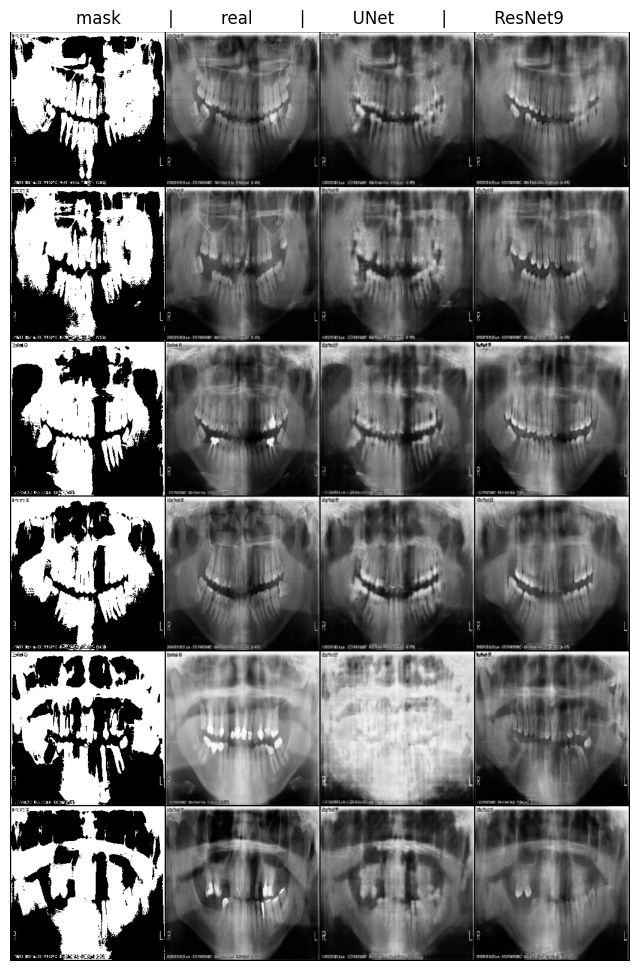

In [22]:

G_unet.eval(); G_res9.eval()
with torch.no_grad():
    msk, real = next(iter(val_loader))      # batch di validation
    msk  = msk.to(DEVICE); real = real.to(DEVICE)
    fake_u = G_unet(msk)
    fake_r = G_res9(msk)

# fallback se non esiste già
try:
    denorm
except NameError:
    denorm = lambda x: (x.clamp(-1,1)+1)*0.5

k = min(6, msk.size(0))

tiles = []
for i in range(k):
    tiles += [msk[i:i+1], real[i:i+1], fake_u[i:i+1], fake_r[i:i+1]]
grid2 = vutils.make_grid(denorm(torch.cat(tiles,0)).cpu(), nrow=4, padding=2)

plt.figure(figsize=(8, k*4))
plt.imshow(grid2.permute(1,2,0)); plt.axis("off")
plt.title("mask         |         real         |         UNet         |         ResNet9")
plt.show()


In [23]:
#postprocessing
match_mean_std_dir(SYN_UNET, SYN_UNET_PP, REAL3_DIR, IMG_SIZE)
match_mean_std_dir(SYN_RES9, SYN_RES9_PP, REAL3_DIR, IMG_SIZE)

Mean-Std match → synthetic_img_res9_pp: 100%|██████████| 200/200 [00:03<00:00, 59.07it/s]


In [24]:
candidates_named = [
    ("UNet",       globals().get("SYN_UNET", "synthetic_img_unet")),
    ("ResNet9",    globals().get("SYN_RES9", "synthetic_img_resnet9")),
    ("UNet_PP",    globals().get("SYN_UNET_PP", "synthetic_img_unet_pp")),
    ("ResNet9_PP", globals().get("SYN_RES9_PP", "synthetic_img_res9_pp")),
]
pairs = [(name, str(Path(path))) for name, path in candidates_named
         if path is not None and Path(path).exists() and count_imgs(path) > 0]
assert pairs, "Nessuna cartella sintetica valida trovata."

# 2) valuta tutte
DEVICE_IS_CUDA = bool(globals().get('DEVICE_IS_CUDA', False))
IMG_SIZE_SAFE  = int(globals().get('IMG_SIZE', 256))
results = {}
folders_map = {}

for name, syn_dir in pairs:
    kid_sub = min(100, count_imgs(REAL3_DIR), count_imgs(syn_dir))
    print(f"\n== Metrics ({name}) ==  kid_subset_size={kid_sub}")
    res = eval_dirs(REAL3_DIR, syn_dir, DEVICE_IS_CUDA, kid_subset_size=kid_sub, kid_subset_count=50, img_size=IMG_SIZE_SAFE)
    results[name] = res
    folders_map[name] = syn_dir
    print(res)

# 3) scegli BEST (kid_mean min, poi fid, poi lpips_mean)
def sort_key(item):
    name, m = item
    return (m["kid_mean"], m["fid"], m.get("lpips_mean", 1e9))
leaderboard = sorted(results.items(), key=sort_key)

best_run = leaderboard[0][0]
best_folder = folders_map[best_run]

print("\n=== Leaderboard (migliore in alto) ===")
for name, m in leaderboard:
    print(f"{name:12s}  KID={m['kid_mean']:.6f}  FID={m['fid']:.2f}  LPIPS={m['lpips_mean']:.4f}")

print(f"\n🏆 best_run = {best_run}")
print(f"📂 best_folder = {best_folder}")

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth



== Metrics (UNet) ==  kid_subset_size=100


100%|██████████| 91.2M/91.2M [00:02<00:00, 32.0MB/s]
/usr/local/lib/python3.12/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'N_real': 200, 'N_syn': 200, 'fid': 142.9711028138501, 'kid_mean': 0.12177961587905883, 'kid_std': 0.0044200084754418955, 'lpips_mean': 0.4451815089583397, 'kid_subset_size': 100, 'kid_subset_count': 50}

== Metrics (ResNet9) ==  kid_subset_size=100
{'N_real': 200, 'N_syn': 200, 'fid': 107.08336388355505, 'kid_mean': 0.07899710893630982, 'kid_std': 0.0035470815228641804, 'lpips_mean': 0.4403759939968586, 'kid_subset_size': 100, 'kid_subset_count': 50}

== Metrics (UNet_PP) ==  kid_subset_size=100
{'N_real': 200, 'N_syn': 200, 'fid': 143.2772124419065, 'kid_mean': 0.12215278148651124, 'kid_std': 0.004465896786337486, 'lpips_mean': 0.44521716877818107, 'kid_subset_size': 100, 'kid_subset_count': 50}

== Metrics (ResNet9_PP) ==  kid_subset_size=100
{'N_real': 200, 'N_syn': 200, 'fid': 106.12329819065198, 'kid_mean': 0.07712041139602661, 'kid_std': 0.0035641329892800323, 'lpips_mean': 0.4408889664709568, 'kid_subset_size': 100, 'kid_subset_count': 50}

=== Leaderboard (migliore in alto) =

In [25]:
folders_map = {
    "UNet": "/content/synthetic_img_unet",
    "ResNet9": "/content/synthetic_img_resnet9",
    "UNet_PP": "/content/synthetic_img_unet_pp",
    "ResNet9_PP": "/content/synthetic_img_res9_pp",
}

# usa il best_run calcolato prima
if best_run not in folders_map:
    raise ValueError(f"Nessun path definito per {best_run}")
best_folder = folders_map[best_run]

print("🏆 Best dataset:", best_run)
print("📂 Cartella da caricare:", best_folder)

🏆 Best dataset: ResNet9_PP
📂 Cartella da caricare: /content/synthetic_img_res9_pp


In [26]:
# Dry-run: conta quante immagini verranno processate
_x = list(iter_xray_files(best_folder))
print(f"Verranno processati SOLO X-ray: {len(_x)} file (skip mask). Esempi:")
print("\n".join([pp for pp,_ in _x[:5]]))


Verranno processati SOLO X-ray: 200 file (skip mask). Esempi:
/content/synthetic_img_res9_pp/101.png
/content/synthetic_img_res9_pp/103.png
/content/synthetic_img_res9_pp/104.png
/content/synthetic_img_res9_pp/105.png
/content/synthetic_img_res9_pp/106.png


In [27]:
SRC_DIR = best_folder
DST_DIR = f"{best_folder}_hm_clahe_denoised"
REAL_DIR = REAL3_DIR
IMG_SIZE = int(IMG_SIZE)

os.makedirs(DST_DIR, exist_ok=True)

real_paths = sorted([p for p in Path(REAL_DIR).iterdir() if p.suffix.lower() in (".png",".jpg",".jpeg",".bmp",".tif",".tiff")])
sel = real_paths[:min(100, len(real_paths))]
stack = []
for p in sel:
    im = Image.open(p).convert("L").resize((IMG_SIZE, IMG_SIZE), Image.BICUBIC)
    stack.append(np.array(im, dtype=np.uint8))
template = np.median(np.stack(stack, axis=0), axis=0).astype(np.uint8)

# --- post-processing lotto ---
paths = sorted([p for p in Path(SRC_DIR).iterdir() if p.suffix.lower() in (".png",".jpg",".jpeg",".bmp",".tif",".tiff")])
clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
done = 0

for p in paths:
    img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)

    # 1) Histogram Matching
    hm = match_histograms(img, template, channel_axis=None)
    hm = np.clip(hm, 0, 255).astype(np.uint8)

    # 2) CLAHE (leggero)
    cl = clahe.apply(hm)

    # 3) Denoise soft (Non-Local Means)
    out = cv2.fastNlMeansDenoising(cl, None, h=3, templateWindowSize=7, searchWindowSize=21)

    cv2.imwrite(str(Path(DST_DIR)/p.name), out)
    done += 1

print(f"Post-processing complete: {done} file → {DST_DIR}")
metrics_pp = eval_dirs(REAL3_DIR, best_folder, DEVICE_IS_CUDA, kid_subset_size=kid_sub)
print("\n(METRICHE dopo Histogram Matching -> CLAHE -> Denoise ", metrics_pp)

Post-processing complete: 200 file → /content/synthetic_img_res9_pp_hm_clahe_denoised

(METRICHE dopo Histogram Matching -> CLAHE -> Denoise  {'N_real': 200, 'N_syn': 200, 'fid': 106.12329819065198, 'kid_mean': 0.07712041139602661, 'kid_std': 0.0035641329892800323, 'lpips_mean': 0.4408889664709568, 'kid_subset_size': 100, 'kid_subset_count': 50}


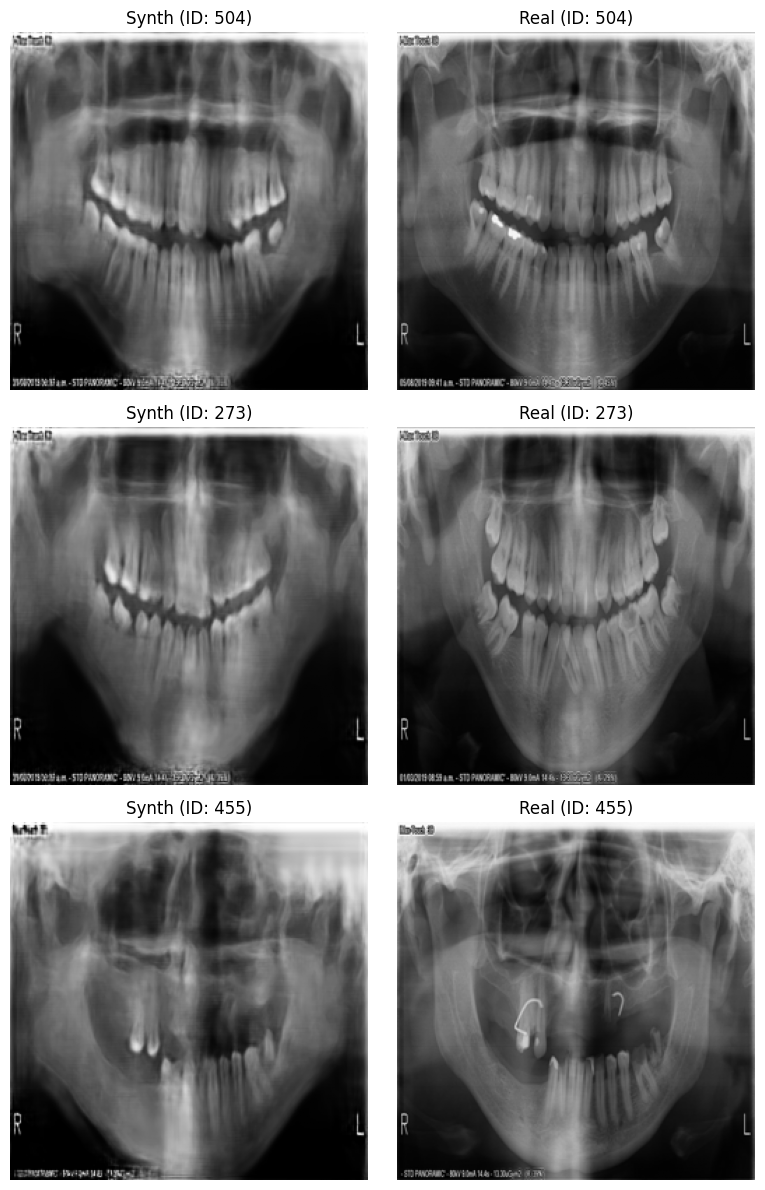

In [28]:
SYN_CHOICE = best_folder
MASK_DIR   = "real3/img"               # ora è il "real" di riferimento
assert Path(MASK_DIR).exists(), f"MASK_DIR non esiste: {MASK_DIR}"

def find_ref_path(stem: str):
    """Trova il real corrispondente: prova più estensioni e suffissi."""
    exts  = [".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"]
    suffs = ["", "_img", "-img", "_mask", "-mask", "_seg", "-seg", "_label", "-label"]
    for suf in suffs:
        for ext in exts:
            cand = Path(MASK_DIR) / f"{stem}{suf}{ext}"
            if cand.is_file():
                return str(cand)
    return None

# 3 instances
syn_files = sorted(glob.glob(os.path.join(SYN_CHOICE, "*.png")))
if len(syn_files) == 0:
    print(f"Nessuna sintetica in '{SYN_CHOICE}'. Rigenera e riesegui.")
else:
    samples = random.sample(syn_files, min(3, len(syn_files)))
    plt.figure(figsize=(8, 4 * len(samples)))

    for i, syn_path in enumerate(samples):
        stem = Path(syn_path).stem  # <- ID
        syn  = cv2.imread(syn_path, cv2.IMREAD_GRAYSCALE)

        ref_path = find_ref_path(stem)
        if ref_path is not None:
            ref = cv2.imread(ref_path, cv2.IMREAD_GRAYSCALE)
            if ref is not None and (ref.shape != syn.shape):
                ref = cv2.resize(ref, (syn.shape[1], syn.shape[0]), interpolation=cv2.INTER_NEAREST)
        else:
            ref = None

        # Synth
        plt.subplot(len(samples), 2, 2*i + 1)
        plt.imshow(syn, cmap="gray"); plt.axis("off")
        plt.title(f"Synth (ID: {stem})")

        # Real
        plt.subplot(len(samples), 2, 2*i + 2)
        if ref is None:
            plt.axis("off"); plt.title(f"Real: not found (ID: {stem})")
        else:
            plt.imshow(ref, cmap="gray"); plt.axis("off")
            plt.title(f"Real (ID: {stem})")

    plt.tight_layout()
    plt.show()


In [29]:
#link to the other colab

In [30]:

best_folder = folders_map[best_run]

# --- crea ZIP con nome fisso ---
ZIP_NAME = "synthetic_IMAGES.zip"
zip_base = "/content/synthetic_IMAGES"   # base name senza estensione
zip_path = f"/content/{ZIP_NAME}"
if os.path.exists(zip_path):
    os.remove(zip_path)
shutil.make_archive(zip_base, 'zip', root_dir=best_folder, base_dir='.')
print(f"✅ ZIP creato: {zip_path} ({os.path.getsize(zip_path)/1e6:.2f} MB)")

# --- upload su catbox (solo questo provider) ---
def upload_catbox(local_file, timeout=300):
    with open(local_file, "rb") as f:
        r = requests.post(
            "https://catbox.moe/user/api.php",
            data={"reqtype": "fileupload"},
            files={"fileToUpload": (os.path.basename(local_file), f)},
            timeout=timeout,
        )
    if r.status_code == 200 and r.text.strip().startswith("http"):
        return r.text.strip()
    raise RuntimeError(f"catbox error {r.status_code}: {r.text[:200]}")

print("📤 Upload su catbox.moe…")
link = upload_catbox(zip_path)
print("\n🔗 Link for download:", link)

✅ ZIP creato: /content/synthetic_IMAGES.zip (9.56 MB)
📤 Upload su catbox.moe…

🔗 Link for download: https://files.catbox.moe/xzc3kd.zip
